# ***Introduction to Vertical Federated Learning*** 

## **Background**

### Vertically Partitioned Data

Often data exists in silos. This can be the case within an organization or among multiple organizations. In each case, the feature of a unique sample is distributed among multple datasets held by different parties. Exchanging data allows the parties to leverage a more complete feature set, thus enhancing the performance of the system. However, privacy restrictions often prevent the parties from doing so. 



### Vertical Federated Learning

Inspired by this limitation, [Vertical Federated Learning](https://blog.openmined.org/federated-learning-types/) (VFL) was introduced. VFL involves training a joint model on data that has features partitioned accross multiple datasets without explictly exchanging the features among parties.
<p align="center">
<img width="433" alt="Screen Shot 2021-09-28 at 5 41 20 PM" src="https://user-images.githubusercontent.com/34798787/135169716-27e0e6a1-1d45-421d-882a-27241805b401.png">
</p>

### Use Case

A logical application of vertical federated learning is in the financial services industry, where several instituions hold credit data for the same individual. Although there is an inherent benenfit of exchanging data, instituions are restricted from doing so. To explore this scenario, we will be using the [Home Credit Default Dataset](https://www.kaggle.com/c/home-credit-default-risk/overview). This dataset contains features about credit applicants drawn from Home Credit's internal operations as well as data from the Credit Bureau. 
<p align="center">
<img width="759" alt="Screen Shot 2021-09-28 at 3 42 48 PM" src="https://user-images.githubusercontent.com/34798787/135170454-f937a987-0dcf-4b3a-a9f9-1bcbeac3bc9f.png">
</p>

In order to apply VFL to this dataset, we have vertically partitioned into two datasets based on the origin of the features, Home Credit or the Credit Bureau. In total, there are ~300000 samples with corresponding labels.  The task at hand is to predicting future payment behavior of clients. 
<p align="center">
<img width="487" alt="Screen Shot 2021-09-29 at 1 40 53 PM" src="https://user-images.githubusercontent.com/34798787/135320845-db616df5-a9bd-4a26-a64d-fdf5c0ba3dcf.png">
</p>


### Tools
In order to perform VFL, data and computation need to be distributed amongst the remote machine(s) of each party. However, deep learning frameworks like PyTorch and TensorFlow do not offer this functionality of the box. Fortunately [PySyft](https://blog.openmined.org/tag/pysyft/), a Python library for secure and private Deep Learning, extends both PyTorch and Keras to provide tools to perform VFL.

## **Demo Overview**
In the following demo, VFL is used to train a joint model between Home Credit and the Credit Bureau to predict whether or not a credit applicants will default using PyTorch and PySyft. During this process, only abstract representations of features are shared thus eliminating the need to explictly exchange features. When coupled with differential privacy, VFL provides a robust solution to privacy preserving AI. 

The follwing demo contains three sections: 
1. **Data Preparation**
    *  Define Vertical Dataloader 
    *  Find correspondences with Private Set Intersection

2. **Model Preparation**
    * Define Sub Model 
    * Define Split Neural Network

3. **Training and Validation**
    * Define train and validation loop
    * Interpret results

# ***Demo*** 

## **Environment Configuration and Package Imports**

In [1]:
import os
import warnings
from uuid import UUID, uuid4

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import syft as sy
import torch
from sklearn.metrics import roc_auc_score
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data._utils.collate import default_collate

hook = sy.TorchHook(torch)

In [2]:
from src.psi.util import Client, Server
from src.utils import add_ids
from src.utils.data_utils import id_collate_fn

## **Data Preparation**

In the data preparation stage, the dataset for Home Credit and the Credit Bureau are initialized. Subsequently, the datasets are passed to a custom dataloader that computes the intersection of records between Home Credit and Credit Bureau using [Private Set Intersection](https://en.wikipedia.org/wiki/Private_set_intersection#:~:text=Private%20set%20intersection%20is%20a,the%20elements%20in%20the%20intersection.). In this way, only the unique identifiers of records are exchanged to compute the intersection. 



<p align="center">
<img width="761" alt="Screen Shot 2021-09-29 at 12 12 33 PM" src="https://user-images.githubusercontent.com/34798787/135307783-8c251791-cf14-4cbd-827a-e1607127156d.png">
</p>


### Define Dataset Class

In [3]:
class VerticalDataset(Dataset):
    """Dataset for Vertical Federated Learning"""

    def __init__(self, ids, data, labels=None):
        """
        Args:
            ids (Numpy Array) : Numpy Array with UUIDS
            data (Numpy Array) : Numpy Array with Features
            targets (Numpy Array) : Numpy Array with Labels. None if not available.
        """
        self.ids = ids
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        """Return record single record"""
        feature = self.data[index].astype(np.float32)

        if self.labels is None:
            label = None
        else:
            label = int(self.labels[index]) if self.labels is not None else None

        id = self.ids[index]

        # Return a tuple of non-None elements
        return (*filter(lambda x: x is not None, (feature, label, id)),)

    def get_ids(self):
        """Return a list of the ids of this dataset."""
        return [str(id_) for id_ in self.ids]

    def sort_by_ids(self):
        """
        Sort the dataset by IDs in ascending order
        """
        ids = self.get_ids()
        sorted_idxs = np.argsort(ids)

        self.data = self.data[sorted_idxs]

        if self.labels is not None:
            self.labels = self.labels[sorted_idxs]

        self.ids = self.ids[sorted_idxs]

### Load Data


In [4]:
# Load Home Credit Data
data_dir = "/ssd003/projects/pets/datasets/home_credit"
HC_DATA_PATH = f"{data_dir}/home_credit_train.csv"
hc_df = pd.read_csv(HC_DATA_PATH)
hc_df.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,target
0,-0.577538,0.142129,-0.478095,-0.166149,-0.507465,-0.149452,1.506880,-0.456215,0.379837,0.579154,...,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,1
1,-0.577538,0.426792,1.725450,0.592677,1.600698,-1.252750,-0.166821,-0.460115,1.078697,1.790855,...,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,0
2,-0.577538,-0.427196,-1.152888,-1.404676,-1.092389,-0.783451,-0.689509,-0.453299,0.206116,0.306869,...,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,0
3,-0.577538,-0.142533,-0.711430,0.177869,-0.653696,-0.928991,-0.680114,-0.473217,-1.375829,0.369143,...,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,0
4,-0.577538,-0.199466,-0.213734,-0.361755,-0.068772,0.563570,-0.892535,-0.473210,0.191639,-0.307263,...,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,0


In [5]:
# Load Credit Bureau Data
CB_DATA_PATH = f"{data_dir}/credit_bureau_train.csv"
cb_df = pd.read_csv(CB_DATA_PATH)
cb_df.head()

,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,-8.210023e-02,-0.067957,-1.805048e-01,-0.313873,-3.594746e-01,-5.176655e-01
1,-8.210023e-02,-0.067957,-1.805048e-01,-0.313873,-3.594746e-01,-1.092866e+00
2,-8.210023e-02,-0.067957,-1.805048e-01,-0.313873,-3.594746e-01,-1.092866e+00
3,3.336720e-17,0.000000,-3.645032e-17,0.000000,-7.516682e-17,-3.831603e-16
4,-8.210023e-02,-0.067957,-1.805048e-01,-0.313873,-3.594746e-01,-1.092866e+00


In [6]:
# Carve out validation set
assert cb_df.shape[0] == hc_df.shape[0]
val_size = 20000
val_ind = np.random.choice(range(cb_df.shape[0]), val_size, replace=False)
hc_df_val = hc_df.iloc[val_ind]
cb_df_val = cb_df.iloc[val_ind]
hc_df.drop(val_ind, axis=0)
cb_df.drop(val_ind, axis=0)

,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,-8.210023e-02,-0.067957,-1.805048e-01,-0.313873,-3.594746e-01,-5.176655e-01
1,-8.210023e-02,-0.067957,-1.805048e-01,-0.313873,-3.594746e-01,-1.092866e+00
2,-8.210023e-02,-0.067957,-1.805048e-01,-0.313873,-3.594746e-01,-1.092866e+00
3,3.336720e-17,0.000000,-3.645032e-17,0.000000,-7.516682e-17,-3.831603e-16
4,-8.210023e-02,-0.067957,-1.805048e-01,-0.313873,-3.594746e-01,-1.092866e+00
...,...,...,...,...,...,...
307506,3.336720e-17,0.000000,-3.645032e-17,0.000000,-7.516682e-17,-3.831603e-16
307507,3.336720e-17,0.000000,-3.645032e-17,0.000000,-7.516682e-17,-3.831603e-16
307508,1.274116e+01,-0.067957,-1.805048e-01,0.859944,-3.594746e-01,-5.176655e-01
307509,-8.210023e-02,-0.067957,-1.805048e-01,-0.313873,-3.594746e-01,-1.092866e+00


In [7]:
# Get UID Column
uuids = np.array([uuid4() for _ in range(len(hc_df))])
uuids_val = np.array([uuid4() for _ in range(len(hc_df_val))])

### Visualize Data

In [8]:
## Home Credit Training Set
print(f"Training \tHome Credit: {str(hc_df.shape)} Credit Bureau: {str(cb_df.shape)}")
print(
    f"Validation: \tHome Credit: {str(hc_df_val.shape)} Credit Bureau: {str(cb_df_val.shape)}"
)

Training 	Home Credit: (307511, 99) Credit Bureau: (307511, 6)
Validation: 	Home Credit: (20000, 99) Credit Bureau: (20000, 6)


### Define Dataloader Classes 


In [9]:
class SinglePartitionDataLoader(DataLoader):
    """DataLoader for a single vertically-partitioned dataset"""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.collate_fn = id_collate_fn


class VerticalDataLoader:
    """Dataloader which batches data from a complete
    set of vertically-partitioned datasets
    i.e. the images dataset AND the labels dataset
    """

    def __init__(self, hc_data, cb_data, *args, **kwargs):

        self.dataloader1 = SinglePartitionDataLoader(hc_data, *args, **kwargs)
        self.dataloader2 = SinglePartitionDataLoader(cb_data, *args, **kwargs)

    def __iter__(self):
        """
        Zip Dataloaders
        """
        return zip(self.dataloader1, self.dataloader2)

    def __len__(self):
        """
        Return length of dataset
        """
        return (len(self.dataloader1) + len(self.dataloader2)) // 2

    def drop_non_intersecting(self, intersection):
        """Remove elements and ids in the datasets that are not in the intersection."""
        self.dataloader1.dataset.data = self.dataloader1.dataset.data[intersection]
        self.dataloader1.dataset.ids = self.dataloader1.dataset.ids[intersection]

        self.dataloader1.dataset.labels = self.dataloader1.dataset.labels[intersection]
        self.dataloader2.dataset.ids = self.dataloader2.dataset.ids[intersection]

    def sort_by_ids(self) -> None:
        """
        Sort each dataset by ids
        """
        self.dataloader1.dataset.sort_by_ids()
        self.dataloader2.dataset.sort_by_ids()

## Initialize Datasets 

In [10]:
# Home Credit Dataset

# Training
hc_labels = np.array(hc_df.pop("target"))
hc_data = np.array(hc_df)
print("train", uuids.shape, hc_data.shape, hc_labels.shape)
hc_dim = hc_data.shape[1]
hc_dataset = VerticalDataset(ids=uuids, data=hc_data, labels=hc_labels)

# Validation
hc_labels_val = np.array(hc_df_val.pop("target"))
hc_data_val = np.array(hc_df_val)
print("train", uuids_val.shape, hc_data_val.shape, hc_labels_val.shape)
hc_dataset_val = VerticalDataset(ids=uuids_val, data=hc_data_val, labels=hc_labels_val)

train (307511,) (307511, 98) (307511,)
train (20000,) (20000, 98) (20000,)


In [11]:
# Credit Bureau Dataset

# Training
cb_data = np.array(cb_df)
print(cb_data.shape)
cb_dim = cb_data.shape[1]
cb_feat_dim = 4
cb_dataset = VerticalDataset(ids=uuids, data=cb_data, labels=None)

# Validation
cb_dataset_val = np.array(cb_df_val)
cb_dataset_val = VerticalDataset(ids=uuids_val, data=cb_dataset_val, labels=None)

(307511, 6)


## Initialize Dataloader

In [12]:
## Initialize Train Dataloader
dataloader = VerticalDataLoader(hc_dataset, cb_dataset, batch_size=2048)

# Compute private set intersection
client_items = dataloader.dataloader1.dataset.get_ids()
server_items = dataloader.dataloader2.dataset.get_ids()

client = Client(client_items)
server = Server(server_items)

setup, response = server.process_request(client.request, len(client_items))
intersection = client.compute_intersection(setup, response)

# Order data
dataloader.drop_non_intersecting(intersection)
dataloader.sort_by_ids()

In [13]:
## Initialize Train Dataloader
val_dataloader = VerticalDataLoader(hc_dataset_val, cb_dataset_val, batch_size=2048)

# Compute private set intersection
val_client_items = val_dataloader.dataloader1.dataset.get_ids()
val_server_items = val_dataloader.dataloader2.dataset.get_ids()

val_client = Client(val_client_items)
val_server = Server(val_server_items)

val_setup, val_response = val_server.process_request(
    val_client.request, len(val_client_items)
)
val_intersection = val_client.compute_intersection(val_setup, val_response)

# Order data
val_dataloader.drop_non_intersecting(val_intersection)
val_dataloader.sort_by_ids()

## **Model Preparation**
In the model preparation stage, both Home Credit and the Credit Bureau initialize a model. Subsequently, a [Split Neural Network](https://arxiv.org/pdf/1810.06060.pdf) (SplitNN) is defined with the Home Credit and Credit Bureau models as submodules. SplitNN orchestrates the flow of data and gradients within and accross submodules that are potentially on different machines. Data shared accross modules is in the form of representations to avoid explicitly exchanging features accross organizations. 
<p align="center">
<img width="400" alt="Screen Shot 2021-09-29 at 1 10 17 PM" src="https://user-images.githubusercontent.com/34798787/135316709-81bdb0ae-591c-4a67-8275-23f10c7b2610.png">
</p>

In this demo, the SplitNN is defined as follows: 
<p align="center">
<img width="500" alt="Screen Shot 2021-09-29 at 1 19 14 PM" src="https://user-images.githubusercontent.com/34798787/135317891-49eb6157-ad14-4ec3-ae85-d5341e23b7c6.png">
</p>

### Model Definitions

In [14]:
class HCModel(torch.nn.Module):
    """
    Model for Credit Bureau

    Attributes
    ----------
    cb_dim:
        Dimensionality of Credit Bureau Data
    Methods
    -------
    forward(x):
        Performs a forward pass through the Credit Bureau Model
    """

    def __init__(self, hc_dim, cb_dim):
        super(HCModel, self).__init__()
        self.fused_input_dim = hc_dim + cb_dim
        self.layers = nn.Sequential(
            nn.Linear(self.fused_input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, hc_feat, cb_feat):
        feat = torch.cat([hc_feat, cb_feat], dim=1)
        pred = self.layers(feat)
        return pred

In [15]:
class CBModel(torch.nn.Module):
    """
    Model for Credit Bureau

    Attributes
    ----------
    cb_dim:
        Dimensionality of Credit Bureau Data
    Methods
    -------
    forward(x):
        Performs a forward pass through the Credit Bureau Model
    """

    def __init__(self, cb_dim):
        super(CBModel, self).__init__()
        self.cb_dim = cb_dim
        self.layers = torch.nn.Sequential(
            nn.Linear(self.cb_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.Sigmoid(),
        )

    def forward(self, cb_feat):
        pred = self.layers(cb_feat)
        return pred

In [16]:
class SplitNN:
    """
    A class representing SplitNN

    Attributes
    ----------
    hc_model:
        Home Credit Neural Network Module

    cb_model:
        Credit Bureau Neural Network Module

    hc_opt:
        Optimizer for the Home Credit Neural Network Module

    cb_model:
        Optimizer for the Credit Bureau Neural Network Module

    data:
        A list storing intermediate computations at each index

    remote_tensors:
        A list storing intermediate computations at each index (Computation from each model detached from global computation graph)

    Methods
    -------
    forward(x):
        Performs a forward pass through the SplitNN

    backward():
        Performs a backward pass through the SplitNN

    zero_grads():
        Zeros the gradients of all networks in SplitNN

    step():
        Updates the parameters of all networks in SplitNN
    """

    def __init__(self, hc_model, cb_model, hc_opt, cb_opt):
        self.hc_model = hc_model
        self.cb_model = cb_model
        self.hc_opt = hc_opt
        self.cb_opt = cb_opt
        self.data = []
        self.remote_tensors = []

    def forward(self, hc_x, cb_x):
        """
        Parameters
        ----------
        x:
            Input Sample
        """

        data = []
        remote_tensors = []

        # Forward pass through first model
        data.append(self.cb_model(cb_x))

        # if location of data is the same as location of the subsequent model
        if data[-1].location == self.hc_model.location:
            # store computation in remote tensor array
            # Gradients will be only computed backward upto the point of detachment
            remote_tensors.append(data[-1].detach().requires_grad_())
        else:
            # else move data to location of subsequent model and store computation in remote tensor array
            # Gradients will be only computed backward upto the point of detachment
            remote_tensors.append(
                data[-1].detach().move(self.hc_model.location).requires_grad_()
            )

        # Get and return final output of model
        data.append(self.hc_model(hc_x, remote_tensors[-1]))

        self.data = data
        self.remote_tensors = remote_tensors
        return data[-1]

    def backward(self):
        # if location of data is the same as detatched data
        if self.remote_tensors[0].location == self.data[0].location:
            # Store gradients from remote_tensor
            grads = self.remote_tensors[0].grad.copy()
        else:
            # Move gradients to lovation of Store grad
            grads = self.remote_tensors[0].grad.copy().move(self.data[0].location)

        self.data[0].backward(grads)

    def zero_grads(self):
        """
        Parameters
        ----------
        """
        self.cb_opt.zero_grad()
        self.hc_opt.zero_grad()

    def step(self):
        """
        Parameters
        ----------
        """
        self.cb_opt.step()
        self.hc_opt.step()

### Initialize and Configure Models

In [17]:
# Training globals
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Iniatialize Home Credit Model and Optimizer
hc_model = HCModel(hc_dim, cb_feat_dim)
hc_opt = torch.optim.Adam(hc_model.parameters(), lr=0.001, betas=(0.9, 0.999))

# Iniatialize Credit Bureau Model and Optmizer
cb_model = CBModel(cb_dim)
cb_opt = torch.optim.Adam(cb_model.parameters(), lr=0.001, betas=(0.9, 0.999))

# Define Split Neural Network
splitNN = SplitNN(hc_model, cb_model, hc_opt, cb_opt)
criterion = torch.nn.BCELoss()

### Configure (Virtual) Remote Workers

In [18]:
# create some workers
hc_worker = sy.VirtualWorker(hook, id="hc")
cb_worker = sy.VirtualWorker(hook, id="cb")

# Send Model Segments to model locations
model_locations = [hc_worker, cb_worker]
models = [hc_model, cb_model]
for model, location in zip(models, model_locations):
    model.send(location)

## Training
In the training phase, the SplitNN is trained jointly. During the forward and backward passes, we have to be ensure that the data and the model is on the same remote machine. 

<p align="center">
<img width="479" alt="Screen Shot 2021-09-29 at 1 27 48 PM" src="https://user-images.githubusercontent.com/34798787/135318913-45308c81-5233-421c-8c03-5aa04060d2e0.png">
</p>

### Training and Validation Loop

In [19]:
def train_step(dataloader, splitNN):
    """ 
    Train Step for Split Neural Network
    
    :param dataloader Train Dataloader
    :param splitNN Split Neural Network that contains Home Credit Model and Credit Bureau Model

    :return: Train Loss
    """ 
    running_loss = 0
    for (hc_data, labels, id1), (cb_data, id2) in dataloader:
        # Send data and labels to machine model is on
        labels = labels.float()
        hc_data = hc_data.send(hc_model.location)
        labels = labels.send(hc_model.location)
        cb_data = cb_data.send(cb_model.location)

        # Zero our grads
        splitNN.zero_grads()

        # Make a prediction
        pred = splitNN.forward(hc_data, cb_data).squeeze()

        # Figure out how much we missed by
        loss = criterion(pred, labels)

        # Backprop the loss on the end layer
        loss.backward()
        splitNN.backward()

        # Change the weights
        splitNN.step()

        # Accumulate Loss
        running_loss += loss.get()

    return running_loss

In [20]:
def val_step(val_dataloader, splitNN):
    """ 
    Val Step for Split Neural Network
    
    :param dataloader Val Dataloader
    :param splitNN Split Neural Network that contains Home Credit Model and Credit Bureau Model

    :return: (auc, accuracy, running_loss)
    """ 
    running_loss = 0
    exs = 0
    correct = 0
    aucs = []
    for (hc_data_val, labels_val, id1), (cb_data_val, id2) in val_dataloader:
        # Send data and labels to machine model is on
        labels_val = labels_val.float()
        hc_data_val = hc_data_val.send(hc_model.location)
        labels_val = labels_val.send(hc_model.location)
        cb_data_val = cb_data_val.send(cb_model.location)

        # Make a prediction
        with torch.no_grad():
            pred = splitNN.forward(hc_data_val, cb_data_val).squeeze()

        # Calcualte Loss
        criterion = torch.nn.BCELoss()
        loss = criterion(pred, labels_val)

        # Calculate AUC
        thresh_pred = (pred > 0.5).float()
        thresh_pred = thresh_pred.get().int()
        labels_val = labels_val.get().int()

        # Fix Me: Undefined for batches with all-same labels...
        auc = roc_auc_score(labels_val, pred.get().numpy())

        # Calculate Accuracy Components
        num_exs = hc_data_val.shape[0]
        num_correct = torch.sum(thresh_pred == labels_val).item()

        # Accumulate loss, accuracy and auc
        exs += num_exs
        correct += num_correct
        running_loss += loss.get()
        aucs.append(auc)

    auc = np.mean(np.array(aucs))
    accuracy = correct / exs

    return auc, accuracy, running_loss

In [21]:
metric_names = ["Train Loss", "Validation Loss", "Accuracy", "AUC"]
metrics = {metric: [] for metric in metric_names}

# Train Loop
for i in range(epochs):

    # Train Step
    train_loss = train_step(dataloader, splitNN)

    # Train Step
    auc, accuracy, val_loss = val_step(val_dataloader, splitNN)

    # Log metrics
    print(f"Epoch: {i} \t AUC: {auc}")
    metrics["Train Loss"].append(train_loss.item())
    metrics["Validation Loss"].append(val_loss.item())
    metrics["Accuracy"].append(accuracy)
    metrics["AUC"].append(auc)

Epoch: 0 	 AUC: 0.7145453521094256
Epoch: 1 	 AUC: 0.7366083803693206
Epoch: 2 	 AUC: 0.7408800797428692
Epoch: 3 	 AUC: 0.743192644812234
Epoch: 4 	 AUC: 0.7446438329399608
Epoch: 5 	 AUC: 0.7457310009234367
Epoch: 6 	 AUC: 0.7465318112471795
Epoch: 7 	 AUC: 0.747448036475046
Epoch: 8 	 AUC: 0.7481950737327906
Epoch: 9 	 AUC: 0.7489257372800021


## Visualize Results

### Load Results


### Display Results


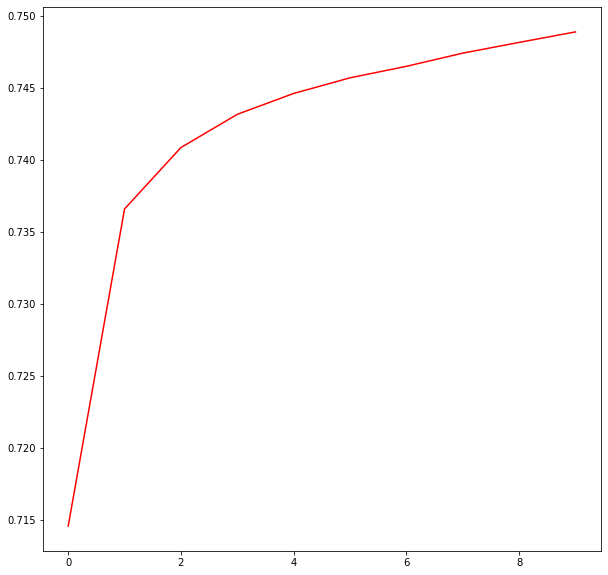

In [22]:
# Visualize Performance
f, axarr = plt.subplots(1, 1, figsize=(10, 10))
(vfl_line,) = axarr.plot(metrics["AUC"], c="red")
vfl_line.set_label("VFL")

## Resources
- [UNDERSTANDING THE TYPES OF FEDERATED LEARNING](https://blog.openmined.org/federated-learning-types/)
- [Distributed learning of deep neural network over multiple agents](https://arxiv.org/pdf/1810.06060.pdf)
- [WHAT IS PYVERTICAL?](https://blog.openmined.org/what-is-pyvertical/)
- [Exploiting Record Similarity for Practical Vertical Federated Learning](https://arxiv.org/pdf/2106.06312.pdf)
